## Dependencies

In [1]:
!nvidia-smi
!jupyter notebook list
%env CUDA_VISIBLE_DEVICES=1

Mon Nov  4 08:17:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0   114W / 149W |   9115MiB / 11441MiB |     24%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:05.0 Off |                    0 |
| N/A   71C    P0    88W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from models import tiramisu_bilinear
from models import tiramisu_m1
from models import tiramisu_m2
from models import unet
from datasets import deepglobe
from datasets import maroads
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

# tensorboard
from torch.utils.tensorboard import SummaryWriter

## Dataset

Download the DeepGlobe dataset from https://competitions.codalab.org/competitions/18467. Place it in datasets/deepglobe/dataset/train,test,valid
Download the Massachusetts Road Dataset from https://www.cs.toronto.edu/~vmnih/data/. Combine the training, validation, and test sets, process with `crop_dataset.ipynb` and place the output in datasets/maroads/dataset/map,sat

In [3]:
run = "expM.2.drop2.1"
DEEPGLOBE_PATH = Path('datasets/', 'deepglobe/dataset')
MAROADS_PATH = Path('datasets/', 'maroads/dataset')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RUNS_PATH    = Path('.runs/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
RUNS_PATH.mkdir(exist_ok=True)

batch_size = 1 # TODO: Should be `MAX_BATCH_PER_CARD * torch.cuda.device_count()` (which in this case is 1 assuming max of 1 batch per card)

In [4]:
# resize = joint_transforms.JointRandomCrop((300, 300))

normalize = transforms.Normalize(mean=deepglobe.mean, std=deepglobe.std)
train_joint_transformer = transforms.Compose([
#     resize,
    joint_transforms.JointRandomHorizontalFlip(),
    joint_transforms.JointRandomVerticalFlip(),
    joint_transforms.JointRandomRotate()
    ])

train_slice = slice(None,4000)
test_slice = slice(4000,None)

train_dset = deepglobe.DeepGlobe(DEEPGLOBE_PATH, 'train', slc = train_slice,
    joint_transform=train_joint_transformer,
    transform=transforms.Compose([
        transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4),
        transforms.ToTensor(),
        normalize,
    ]))

train_dset_ma = maroads.MARoads(MAROADS_PATH, 
    joint_transform=train_joint_transformer,
    transform=transforms.Compose([
        transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4),
        transforms.ToTensor(),
        normalize,
    ]))

# print(len(train_dset_ma.imgs))
# print(len(train_dset_ma.msks))
train_dset_combine = torch.utils.data.ConcatDataset((train_dset, train_dset_ma))

# train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)
# train_loader = torch.utils.data.DataLoader(train_dset_ma, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    train_dset_combine, batch_size=batch_size, shuffle=True)





# resize_joint_transformer = transforms.Compose([
#     resize
#     ])
resize_joint_transformer = None
val_dset = deepglobe.DeepGlobe(
    DEEPGLOBE_PATH, 'valid', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = deepglobe.DeepGlobe(
    DEEPGLOBE_PATH, 'train', joint_transform=resize_joint_transformer, slc = test_slice,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 4909
Val: 1243
Test: 2226
Inputs:  torch.Size([1, 3, 1024, 1024])
Targets:  torch.Size([1, 1024, 1024])


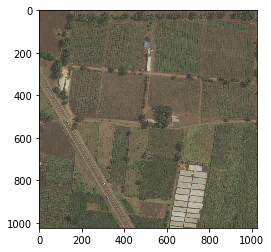

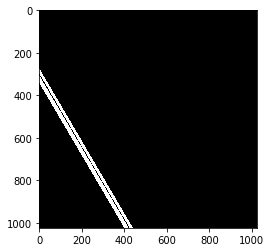

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [5]:
print("Train: %d" %len(train_loader.dataset))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
# print("Classes: %d" % len(train_loader.dataset.classes))

print((iter(train_loader)))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
# utils.imgs.view_image(targets[0])
utils.imgs.view_annotated(targets[0])

print(targets[0])

## Train

In [6]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0)

In [7]:
from utils.bceloss import dice_bce_loss
from loss.BCESSIM import BCESSIM

model = tiramisu_m2.FCDenseNetSmall(n_classes=1, dropout_rate=0.2).cuda()

optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)

# criterion = dice_bce_loss()
criterion = BCESSIM()

# from torchsummary import summary
# summary(model, input_size=inputs[0].shape)

In [8]:
start_epoch = 0
# start_epoch = train_utils.load_weights(model, (train_utils.WEIGHTS_PATH+'latest.th'))
print("Starting from epoch", start_epoch)

Starting from epoch 0


In [9]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter(log_dir=(RUNS_PATH.as_posix() + "/" + "run" + str(run) + "/"))

In [ ]:
from torch.autograd import Variable

debug_max_size=None

# break # errors. Used to stop "run all"
for epoch in range(start_epoch, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch, debug_max_size=debug_max_size)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    tes_loss, tes_err, tes_iou = train_utils.test(model, test_loader, criterion, epoch, debug_max_size=debug_max_size)    
    print('Tes - Loss: {:.4f} | Acc: {:.4f}'.format(tes_loss, 1-tes_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    val_loss = trn_loss
    val_err = trn_err
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, tes_loss, tes_err)

    ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)
    
    # Log on tensorboard
    writer.add_scalar('Loss/train', trn_loss, epoch)
    writer.add_scalar('Loss/test', tes_loss, epoch)
    
    writer.add_scalar('Error/train', trn_err, epoch)
    writer.add_scalar('Error/test', tes_err, epoch)
    
#     writer.add_scalar('Accuracy/train', trn_iou, epoch)
    writer.add_scalar('Accuracy/test', tes_iou, epoch)
    
#     writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#     writer.add_scalar('Accuracy/test/noaug', do_valid(False), epoch)
#     writer.add_scalar('Accuracy/test/tta', do_valid(True), epoch)
    for param_group in optimizer.param_groups:
        writer.add_scalar('Params/learning_rage', param_group['lr'], epoch)
#     writer.add_scalar('params/learning_rate', optimizer.lr, epoch)
#     writer.add_scalar('Params/no_optim', no_optim, epoch)

    # log a sample image
    for i in range(3):
        inputs, targets, pred, loss, err, iou = train_utils.get_sample_predictions(model, test_loader, n=1, criterion=criterion)
        raw = model(inputs.cuda()).cpu()        
        img = torchvision.utils.make_grid(torch.stack([
            inputs[0],
            targets[0].unsqueeze(0).expand(3,-1,-1).float(), 
            pred[0].unsqueeze(0).expand(3,-1,-1).float(),
            raw[0].expand(3,-1,-1).float()
        ]), normalize=True)
        
        writer.add_image('test/sample_pred', img, epoch)
        break
    
    start_epoch = epoch


torch.cuda.device_count() 1
multiplier 16.0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 0
Train - Loss: 0.2604, Acc: 0.0030
Train Time 76m 12s
Tes - Loss: 0.1954 | Acc: 0.0000
Total Time 89m 12s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 1
Train - Loss: 0.1965, Acc: 0.0475
Train Time 74m 35s
Tes - Loss: 0.1730 | Acc: 0.0920
Total Time 87m 16s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 2
Train - Loss: 0.1735, Acc: 0.1459
Train Time 74m 35s
Tes - Loss: 0.1661 | Acc: 0.1347
Total Time 87m 42s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 3
Train - Loss: 0.1565, Acc: 0.2007
Train Time 74m 57s
Tes - Loss: 0.1639 | Acc: 0.2063
Total Time 87m 33s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 4
Train - Loss: 0.1452, Acc: 0.2347
Train Time 74m 45s
Tes - Loss: 0.1518 | Acc: 0.2215
Total Time 87m 14s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 5
Train - Loss: 0.1371, Acc: 0.2642
Train Time 74m 44s
Tes - Loss: 0.1479 | Acc: 0.2644
Total Time 87m 17s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 6
Train - Loss: 0.1314, Acc: 0.2864
Train Time


## Test

In [ ]:
# returns test_loss, test_error, jaccard
train_utils.test(model, test_loader, criterion, epoch=1)

In [ ]:
stats = train_utils.view_sample_predictions(model, test_loader, n=1, criterion=criterion)
print("loss", "error", "jaccard")
print(stats)


In [ ]:
# !pip install torchsummary
from torchsummary import summary
summary(model, input_size=inputs[0].shape)